### Cat Classification Model


In [1]:
%%bash
pwd


/workspaces/87508020/Final_Project


In [2]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-10-26 13:54:56.244360: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-26 13:54:56.247301: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-26 13:54:56.255799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1729922096.269599    8441 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1729922096.273751    8441 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 13:54:56.288861: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

2.18.0
Num GPUs Available:  0


2024-10-26 13:54:58.910588: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


#### Load Dataset from Local Folder

In [3]:
import os
from pathlib import Path
import numpy as np

# path setup
BASE_DIR = "./"
PATH_DATASET = Path(BASE_DIR/Path("cat_breed"))
PATH_TRAINSET = Path(PATH_DATASET/Path("TRAIN"))
PATH_TESTSET = Path(PATH_DATASET/Path("TEST"))

class_list = os.listdir(PATH_TRAINSET)

# check the amount of data
for i in class_list:
  train_image_list = [name for name in os.listdir(os.path.join(PATH_TRAINSET,i))]
  test_image_list = [name for name in os.listdir(os.path.join(PATH_TESTSET,i))]
  train_image_count = len(train_image_list)
  test_image_count = len(test_image_list)
  print(f"class {i:7s} contain {train_image_count} train images and {test_image_count} test images")

class americanshorthair contain 151 train images and 37 test images
class sphinx  contain 194 train images and 47 test images
class bengal  contain 126 train images and 32 test images
class scottishfold contain 179 train images and 43 test images
class ragdoll contain 141 train images and 31 test images
class mainecoon contain 119 train images and 31 test images


In [4]:
# load dataset
img_height = 256
img_width = 256
# using batch training/ mini-batch GD
batch_size = 8

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TRAINSET,
    validation_split=0.2,
    subset="training",
    seed=2024,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TRAINSET,
    validation_split=0.2,
    subset="validation",
    seed=2024,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

class_names = train_ds.class_names
print(class_names)

# do this prefetch step for faster training, image data will be loaded in background and transfer in sram/cache for later use
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 910 files belonging to 6 classes.


Using 728 files for training.
Found 910 files belonging to 6 classes.
Using 182 files for validation.
['americanshorthair', 'bengal', 'mainecoon', 'ragdoll', 'scottishfold', 'sphinx']


In [5]:
# remove image that tf not accepted
from pathlib import Path
import imghdr
import shutil

data_dir = "/home/user/datasets/samples/"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(PATH_DATASET).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

/tmp/ipykernel_8441/627096637.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


2024-10-26 13:55:03.501148: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38415510 exceeds 10% of free system memory.
2024-10-26 13:55:04.388778: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24883200 exceeds 10% of free system memory.
2024-10-26 13:55:04.874945: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150962688 exceeds 10% of free system memory.
2024-10-26 13:55:05.785466: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23760000 exceeds 10% of free system memory.
2024-10-26 13:55:05.836196: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59885568 exceeds 10% of free system memory.
2024-10-26 13:55:06.325604: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


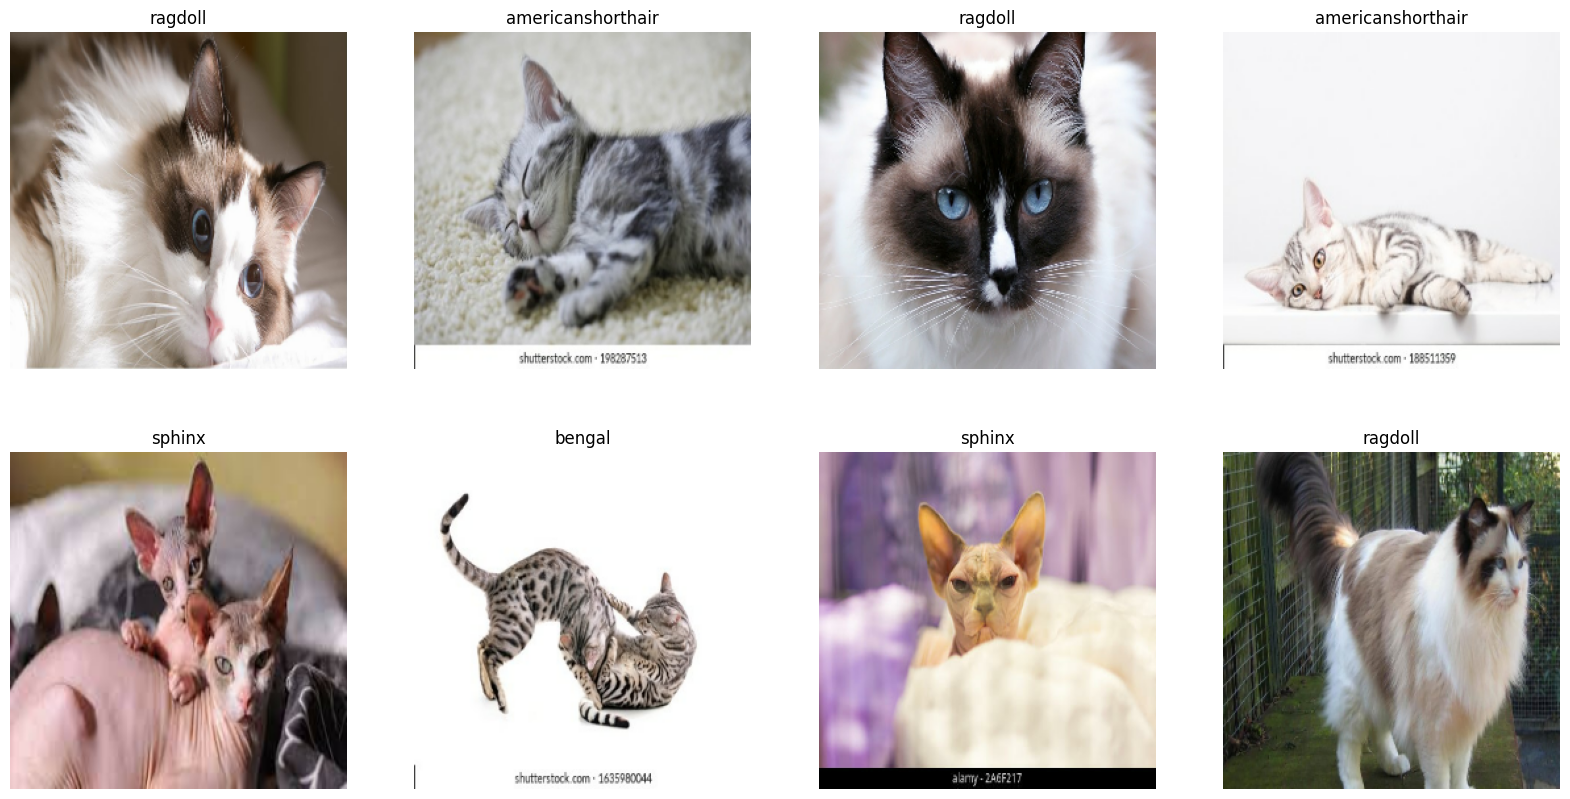

In [6]:

# visualize some of image (it takes some time for the first run)
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# take one batch (8 image = 1 batch = 1 step) from train_dataset
for images, labels in train_ds.take(1):
  # print(images, labels)
  for i in range(8):
    ax = plt.subplot(2,4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# create model
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  # layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='sigmoid')
])

# Note: use sparseCE if provide labels as integer (e.g. the class of 4 images [0,1,1,2]); use CE for one-hot label (e.g. [0,0,2,0])
#   Metrics are the same
# opt = tf.optimizers.SGD(lr=0.001)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
## from_logits = False: prediction = btw 0,1 (softmax output)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
              )

/home/ubuntu/.local/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
import keras
from keras.models import Sequential
import tensorflow as tf
import keras.layers as layers

def AlexNet(input_shape, n_classes, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = keras.Sequential()
  model.add(layers.Rescaling(1./255, input_shape=input_shape))
  model.add(layers.Conv2D(filters=96, kernel_size=(11, 11),
                          strides=(4, 4), activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(3, 3), strides= (2, 2)))
  model.add(layers.Conv2D(filters=256, kernel_size=(5, 5),
                          strides=(1, 1), activation="relu",
                          padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
  model.add(layers.Conv2D(filters=384, kernel_size=(3, 3),
                          strides=(1, 1), activation="relu",
                          padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=384, kernel_size=(3, 3),
                          strides=(1, 1), activation="relu",
                          padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=256, kernel_size=(3, 3),
                          strides=(1, 1), activation="relu",
                          padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(n_classes, activation="softmax"))

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

# choose the last n fine_tune layers for training
num_classes = len(class_names)

input_shape = (256, 256,3)
model = AlexNet(
    input_shape=input_shape,
    n_classes=num_classes,
)

model.summary()

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │       393,222 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 416,806 (1.59 MB)

 Trainable params: 416,806 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
epochs=10
from keras.callbacks import EarlyStopping,ModelCheckpoint
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5,restore_best_weights=True),
    # ModelCheckpoint(filepath="simple_model_at_ep{epoch}.h5",
    #             save_best_only=True,
    #             save_weights_only=True,
    #             monitor='val_accuracy',
    #             mode='max')
    ModelCheckpoint(
        filepath="weights/save_at_{epoch}.h5.keras",
        # save_weights_only=True
        ),
]

history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=callbacks,
  epochs=epochs
)

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 32s 336ms/step - loss: 1.8598 - sparse_categorical_accuracy: 0.2404 - val_loss: 1.5672 - val_sparse_categorical_accuracy: 0.4121
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 39s 318ms/step - loss: 1.3481 - sparse_categorical_accuracy: 0.4601 - val_loss: 1.3827 - val_sparse_categorical_accuracy: 0.4231
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - loss: 0.9815 - sparse_categorical_accuracy: 0.6541 - val_loss: 1.4860 - val_sparse_categorical_accuracy: 0.4835
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 310ms/step - loss: 0.6335 - sparse_categorical_accuracy: 0.7673 - val_loss: 1.6721 - val_sparse_categorical_accuracy: 0.4945
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 308ms/step - loss: 0.2855 - sparse_categorical_accuracy: 0.9148 - val_loss: 1.7857 - val_sparse_categorical_accuracy: 0.4451
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - loss: 0.1520 - sparse_categorical_accuracy: 0.9528 - val_loss: 2.3847 - val_sparse_categorical_accuracy: 0.472

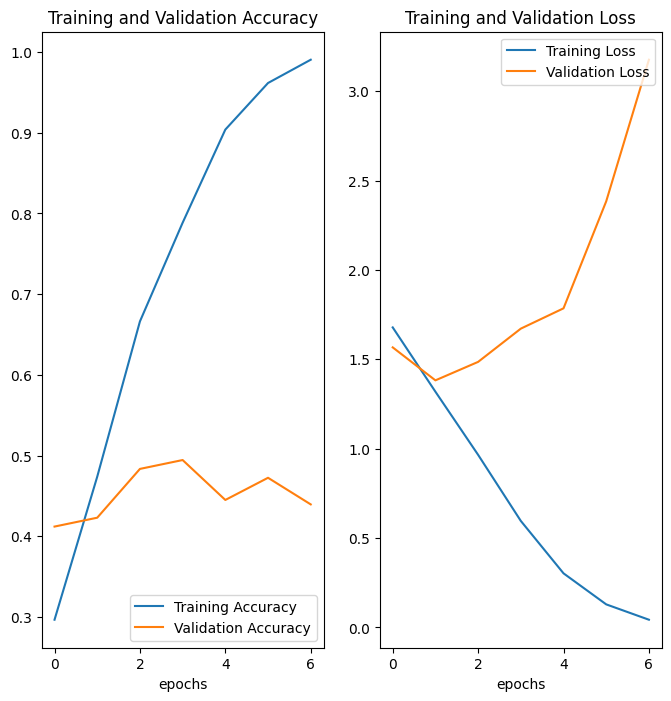

In [10]:
# plot the training dynamic
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.show()

In [11]:
import time
import glob

TEST_IMAGES_LIST = glob.glob(os.path.join(PATH_DATASET, "TEST/*/*.jpg"))

for test_img in TEST_IMAGES_LIST[:50]:
  start_time = time.time()

  img = tf.keras.utils.load_img(test_img, target_size=(img_height, img_width))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  # predictions = model.predict(img_array)
  score = np.max(predictions[0])  # softmax result (prob/confidence)
  img_name = os.path.basename(test_img)
  end_time = time.time()
  elasped_time = end_time - start_time
  print(
      "Image name ({:15s}) most likely belongs to {} with a {:.2f} percent confidence. Time used: {:.3f}s."
      .format(img_name,class_names[np.argmax(predictions)], 100 * np.max(score),elasped_time)
  )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Image name (american-shorthair-cat-on-colored-260nw-1432734227.jpg) most likely belongs to mainecoon with a 21.93 percent confidence. Time used: 0.107s.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image name (american-shorthair-cat-sitting-looking-260nw-409165993.jpg) most likely belongs to americanshorthair with a 45.99 percent confidence. Time used: 0.058s.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image name (american-shorthair-cat-room-260nw-512486245.jpg) most likely belongs to ragdoll with a 63.62 percent confidence. Time used: 0.054s.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image name (american-shorthair-cat-hugging-her-260nw-1037942209.jpg) most likely belongs to ragdoll with a 66.45 percent confidence. Time used: 0.052s.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image name (american-shorthair-cat-white-background-260nw-93919351.jpg) most likely belongs to americanshorthair with a 38.82 percent confidence. Time used: 0.052s.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

In [12]:
### visualize the result using confusion matrix
PATH_TESTSET = Path(PATH_DATASET/Path("TEST"))

test_ds = tf.keras.utils.image_dataset_from_directory(
  PATH_TESTSET,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  seed=2022,
  shuffle=False
)

class_names = test_ds.class_names # ordered list of class names

## get and count true classes
y_true = []
for images, label in test_ds:
    for e in label:
        y_true.append(class_names[e]) # list of class names associated with each image file in test dataset

## get and count predicted classes
y_pred = []
preds = model.predict(test_ds, verbose=1) # predict on the test data
# preds = model.predict(test_ds, verbose=1) # predict on the test data
for i, p in enumerate(preds):
    index = np.argmax(p) # get index of prediction with highest probability
    klass = class_names[index]
    y_pred.append(klass)

## compare predicted and true classes
print("y_ture:",y_true)
print("y_pred",y_pred)

Found 221 files belonging to 6 classes.


 1/28 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step

2024-10-26 14:00:21.134547: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step
y_ture: ['americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'americanshorthair', 'bengal', 'bengal', 'bengal', 'bengal', 'bengal', 'bengal', 'bengal', 'bengal', 'bengal', 'bengal', 'bengal', 'bengal', 'bengal', 'bengal', 'bengal', 'bengal', 'bengal', 'be

the accuracy of the model: 39.82 % 
classification report:
                   precision    recall  f1-score   support

americanshorthair       0.56      0.24      0.34        37
           bengal       0.46      0.66      0.54        32
        mainecoon       0.45      0.16      0.24        31
          ragdoll       0.29      0.74      0.41        31
     scottishfold       0.42      0.47      0.44        43
           sphinx       0.50      0.21      0.30        47

         accuracy                           0.40       221
        macro avg       0.45      0.41      0.38       221
     weighted avg       0.45      0.40      0.38       221



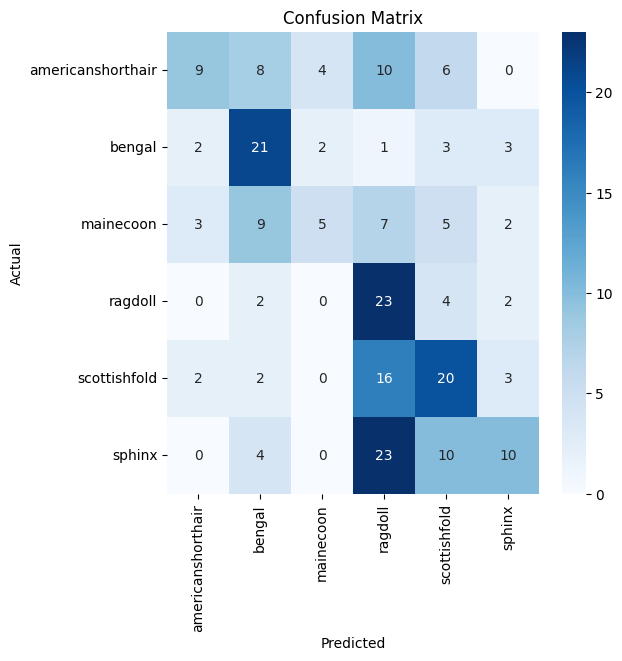

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

## calc accuracy
acc= accuracy_score(y_true,y_pred)
msg=f'the accuracy of the model: {acc*100:.2f} % '
print(msg)

## classification report
clf_report = classification_report(y_true,y_pred)
print(f"classification report:\n{clf_report}")

## plot confusion matrix
y_pred=np.array(y_pred)
y_true=np.array(y_true)
if len(class_names) <= 30: # if more than 30 classes plot is not useful to cramed
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        length = len(class_names)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=True)
        plt.xticks(np.arange(length)+.5, class_names, rotation= 90)
        plt.yticks(np.arange(length)+.5, class_names, rotation= 0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()